In [1]:
import fastbook
fastbook.setup_book()

In [2]:
from fastbook import *
from fastai.vision.widgets import *

## Gathering Data

In [9]:
search_images_ddg

<function fastbook.search_images_ddg(term, max_images=200)>

In [10]:
ims = search_images_ddg('grizzly bear')
len(ims)

200

In [15]:
ims[1]

'http://wallpaper.imcphoto.net/animals/grizzly-bear/giant-grizzly-bear.jpg'

In [14]:
dest = 'images/grizzly.jpg'
download_url(ims[1], dest)   # downloads image from first url to destination specified

Path('images/grizzly.jpg')

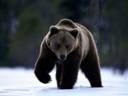

In [16]:
im = Image.open(dest)   # creates Image object with image from destination
im.to_thumb(128, 128)   # print image with secified dimensions

Create a 'bears' folder as a Path object then use fatai's download_images to download images for each type of bear to that folder.

In [21]:
bear_types = 'grizzly', 'black', 'teddy'    # creating folders to catagorize the images
path = Path('bears')

if not path.exists():
    path.mkdir()    # create a new directory
    for o in bear_types:
        dest = (path/o)    # the '/' sign is an operator to create new folders for Path objects
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f'{o} bear')
        download_images(dest, urls=results)
        

Check which files that were downloaded are corrupt:

In [22]:
failed = verify_images(get_image_files(path))
failed

(#47) [Path('bears/black/30ce6cb5-180a-4659-a364-04d202aa73ca.jpg'),Path('bears/black/4b0cf234-3c96-49ca-9806-408a7eec649d.jpg'),Path('bears/black/62351383-a6ec-4f93-a348-1f30848e0913.jpg'),Path('bears/black/641f8178-ca06-49d8-8ddb-d4452e2a859e.jpg'),Path('bears/black/a498e00b-998a-400f-914a-4abbdd7b674f.jpg'),Path('bears/black/a83e3962-4115-4da8-aa01-7e992b280cae.png'),Path('bears/black/d53f5108-1ea3-443d-8a06-496bcf78e970.jpg'),Path('bears/black/e3356a7c-e7c1-4b66-90b3-fa19715a2935.jpg'),Path('bears/grizzly/01f4ea61-501a-40f9-a1fc-516fa4ce5b2b.jpg'),Path('bears/grizzly/0b8a6451-3dbb-4e61-8c35-bff33b0ead2e.jpg')...]

Remove corrupted files; this is done with the .unlink() method:

In [25]:
failed.map(Path.unlink);

### Getting Information about Functions

In [5]:
?search_images_ddg    # gives summary info pop-up

In [8]:
??search_images_ddg   # gives full source-code in pop-up

In [3]:
doc(search_images_ddg)

**Handy Trick:** If you select text and hit '(' it will add parentheses around the entire text!

In [4]:
doc(verify_images)    # provides a link to documentation when possible

In [ ]:
%debug   # this opens the python debugger which will let us inspect the contents of every variable

### From Data to DataLoaders

The DataLoaders class in fastai is a wrapper for storing whatever DataLoader objects get passed to it. It also makes these DataLoader objects available as train and valid. Using DataLoaders, we can wrap multipl DataLoader objects together.

DataLoaders objects need to know:
- What kinds of data we are working with
- How to get the list of items
- How to label the items
- How to create the validation set

The DataBlock is an API to customize the creation of DataLoaders objects:

This `DataBlock` object serves as a template for creating a `DataLoaders` object, which we can do with the `.dataloaders()` method - passing a path argument to specify the data's source folder (this argument will be inherited by the `get_image_files` function and the `parent_labels` function. 

In [4]:
# Generic container to quickly build `Datasets` and `DataLoaders`
bears = DataBlock(
    # Define blocks for the data and labels
    blocks=(
        # A `TransformBlock` for images
        ImageBlock, 
        # A `TransformBlock` for single-label categorical targets
        CategoryBlock
    ), 
    # Get image files in `path` recursively
    get_items=get_image_files, 
    # Create function that splits `items` between train/val with `valid_pct` randomly
    splitter=RandomSplitter(
        # Use 20% of data for validation set
        valid_pct=0.2, 
        # Set random seed to get the same split across different training sessions
        seed=42
    ),
    # Label `item` with the parent folder name
    get_y=parent_label,
    # Resize and crop image to 128x128
    item_tfms=Resize(128))

In [5]:
# Create a `DataLoaders` object from `path`
dls = bears.dataloaders(path)

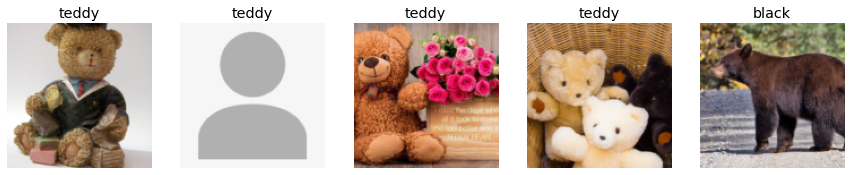

In [12]:
# Show some samples from the validation set
dls.valid.show_batch(max_n=5, nrows=1)

### Data Augmentation

We can augment this dataset by creating random variations of the input data such that the items appear different without compromising their meaningful information. Examples include flipping, rotating, perspective warping, and brightness changes. For images of the same size, the fastai `aug_transforms` function allows us to apply augmentation transformations on batches of the images using the GPU. 

This process allows us to augment the amount of data that we have for training.

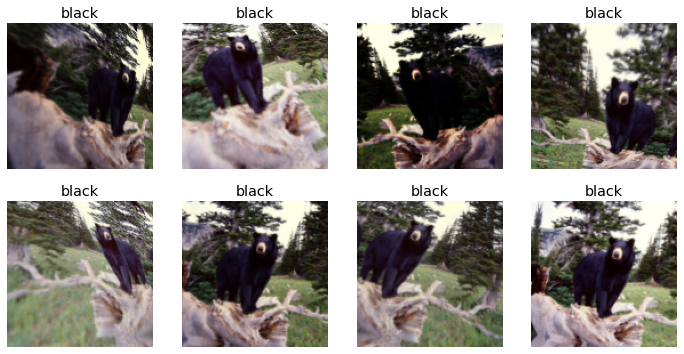

In [13]:
bears = bears.new(item_tfms=Resize(128),              # resize all images to (128, 128)
                  batch_tfms=aug_transforms(mult=2))  # apply aug_transforms to all images
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

Here, the `item_tfms` are transformations applied to the items of the dataset while `batch_tfms` are transformations applied to the batches of items.

## Training the Model - and Using it to Clean the Data

First, we augment the dataset using `aug_transfomrs` and `RandomResizedCrop`. This latter function crops each image to ther specified dimensions but does so over a randomized subsection of the image. In this way, we can produce many more images that are same-sized-subsections of the original images. Then, of course, we can further expand the dataset using `aug_transforms`.

In [16]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5), # min_scale is minimum amount of image: 50%
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [18]:
learn = vision_learner(dls=dls,
                       arch=resnet18,    # specify architecture of model
                       metrics=error_rate)
learn.fine_tune(4)    # run for 4 epochs

C:\Users\benak\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\benak\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\benak/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.391630,0.224076,0.112500,00:17


epoch,train_loss,valid_loss,error_rate,time
0,0.257755,0.099351,0.025000,00:15
1,0.181925,0.124377,0.037500,00:15
2,0.151527,0.146310,0.025000,00:15
3,0.127549,0.146598,0.025000,00:15


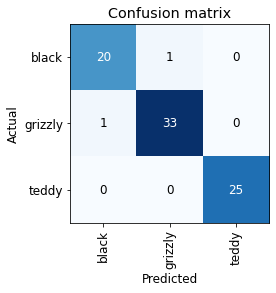

In [19]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

We can look at the loss and prediction probability (softmax?) of each item of the dataset using `plot_top_losses`:

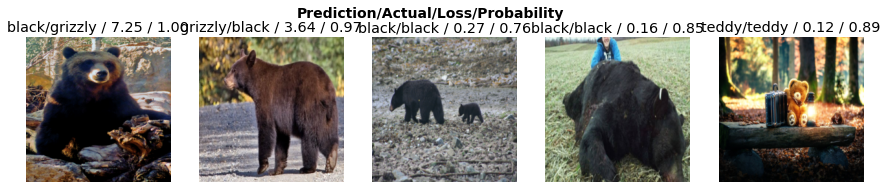

In [20]:
interp.plot_top_losses(5, nrows=1)

The model was positive (predicted with probability of 1.00) that the image with the highest loss was a black bear and not a grizzly bear. It is possible that this image, which appears ambiguous and may well be a black bear, was just mislabeled! This is an example of how data cleaning can be done *after* training the model. This specific type of cleaning is facilitated very well by the `ImageClassifierCleaner` from fastai:

In [21]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [22]:
# then we make the changes that we selected with:
for idx, cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Turning the Model into an Online Application

Save the model using the `export` method:

In [23]:
learn.export()

In [24]:
path = Path()
path.ls(file_exts='.pkl')   # checking that exported model exists in base_dir with fastai's .ls()

(#1) [Path('export.pkl')]

Load in the model to do inference:

In [25]:
learn_inf = load_learner(path/'export.pkl')

In [26]:
learn_inf.predict('images/grizzly.jpg')

('grizzly', tensor(1), tensor([1.1733e-05, 9.9997e-01, 1.6718e-05]))

Returns predicted category, index of the predicted category, and the probability of selecting each category. The ordering of these categories is determined by the `vocab` attribute of the `DataLoaders` object:

In [27]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

### Creating a Notebook App

Use IPython widgets!

In [29]:
# drag-and-drop file uploader to upload images
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [33]:
img = PILImage.create(btn_upload.data[-1])    # fastai object that is an RGB image from Pillow module

# widget to display uploaded image
out_pl = widgets.Output()
out_pl.clear_output()    # clear pre-existing output
with out_pl: display(img.to_thumb(128, 128))
out_pl

Output()

In [34]:
# run predictions
pred, pred_idx, probs = learn_inf.predict(img)

Use a `Label` widget to display predictions:

In [35]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: teddy; Probability: 0.8856')

Lmao, Lars is a teddy bear

In [36]:
# classification button
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

A ***click event handler*** is a function that will be called whenever this button is pressed. Specifically, we want the predictions to be run whenever the button is pressed.

In [37]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

Now we can wrap these features up into a simple GUI:

In [38]:
btn_upload = widgets.FileUpload()
VBox([widgets.Label('Select your bear!'),
      btn_upload, btn_run, out_pl, lbl_pred])

### Turning this Notebook App into a Real App

**Tip:** Cells that begin with a `!` do not contain Python code, but code that is passed to the shell.

#### Voila

"Voilà runs Jupyter notebooks just like the Jupyter notebook server you are using now does, but it also does something very important: it removes all of the cell inputs, and only shows output (including ipywidgets), along with your markdown cells. So what's left is a web application! To view your notebook as a Voilà web application, replace the word "notebooks" in your browser's URL with: "voila/render". You will see the same content as your notebook, but without any of the code cells."

### Deploying the App